In [1]:
import pandas as pd
import numpy as np
from time import time
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import cudf

/ext3/miniconda3/lib/python3.9/site-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [2]:
start_time = time()
# df_raw = cudf.read_csv('train.csv').to_pandas()
df_raw = pd.read_csv('train.csv')
print(time()-start_time)

95.83355641365051


In [3]:
df_raw.head()
len(df_raw)

55423856

### Data Cleaning

In [4]:
df_train = df_raw.copy()
null_rows = df_train.isnull().any(axis=1)
print('number of rows contain null values: {}'.format(np.sum(null_rows)))
df_train = df_train[~null_rows]

df_train.describe()

number of rows contain null values: 376


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07
mean,1.134500e+01,-7.250973e+01,3.991982e+01,-7.251121e+01,3.992068e+01,1.685391e+00
std,2.071087e+01,1.284878e+01,9.642324e+00,1.278220e+01,9.633346e+00,1.327662e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [5]:
# q1 = df_train['fare_amount'].quantile(0.25)
# q3 = df_train['fare_amount'].quantile(0.75)
# iqr = q3 - q1
# threshold = 6
# outlier_rows = (df_train['fare_amount'] < (q1 - threshold * iqr)) | (df_train['fare_amount'] > (q3 + threshold * iqr)) | (df_train['fare_amount'] <= 0)

outlier_rows = (df_train['fare_amount'] <= 0) | (df_train['fare_amount'] > 80)
df_train = df_train[~outlier_rows]
df_train = df_train[df_train['passenger_count'] <= 8]

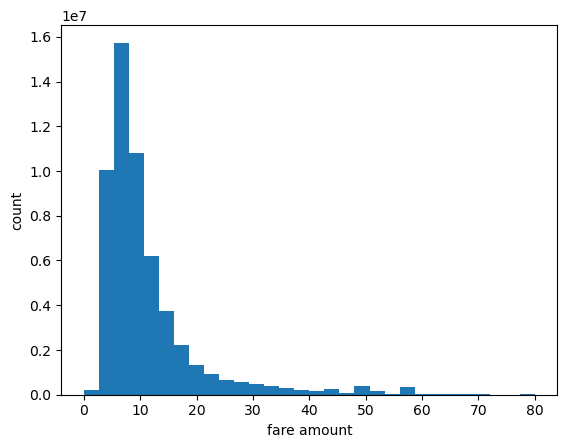

In [6]:
plt.hist(df_train['fare_amount'], bins=30)
plt.xlabel('fare amount')
plt.ylabel('count')
plt.show()

In [7]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    threshold = 5
    outlier_rows = (df[column] < (q1 - threshold * iqr)) | (df[column]> (q3 + threshold * iqr))
    return df[~outlier_rows]

df_train = remove_outliers(df_train, 'pickup_longitude')
df_train = remove_outliers(df_train, 'pickup_latitude')
df_train = remove_outliers(df_train, 'dropoff_longitude')
df_train = remove_outliers(df_train, 'dropoff_latitude')

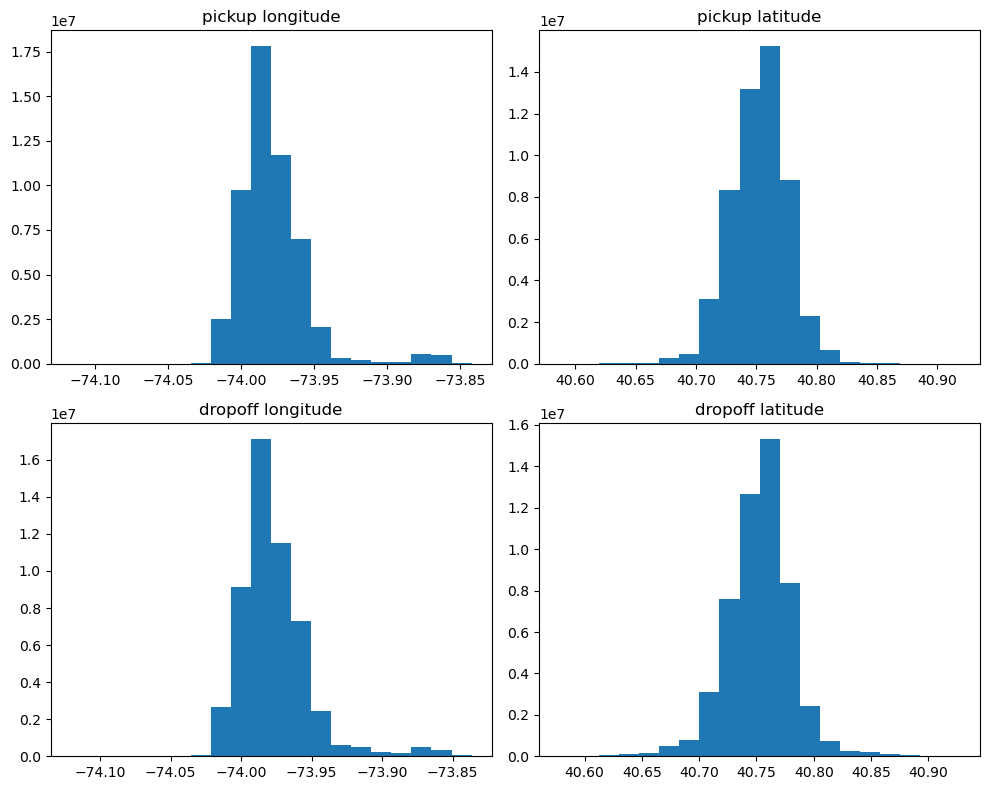

In [8]:
fig, axs = plt.subplots(2, 2,  figsize=(10, 8))
axs[0, 0].hist(df_train['pickup_longitude'], bins=20)
axs[0, 0].set_title('pickup longitude')

axs[0, 1].hist(df_train['pickup_latitude'], bins=20)
axs[0, 1].set_title('pickup latitude')

axs[1, 0].hist(df_train['dropoff_longitude'], bins=20)
axs[1, 0].set_title('dropoff longitude')

axs[1, 1].hist(df_train['dropoff_latitude'], bins=20)
axs[1, 1].set_title('dropoff latitude')

plt.tight_layout()
plt.show()

### Transformation

In [9]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

In [10]:
lon1 = df_train['pickup_longitude'].values
lat1 = df_train['pickup_latitude'].values
lon2 = df_train['dropoff_longitude'].values
lat2 = df_train['dropoff_latitude'].values

start_time = time()
df_train['distance'] = haversine_np(lon1, lat1, lon2, lat2)
print('Time for calculating haversine', time()-start_time)

Time for calculating haversine 2.573138475418091


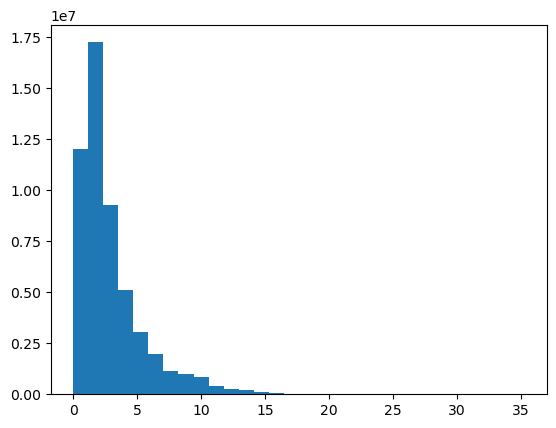

In [11]:
plt.hist(df_train['distance'], bins=30)
plt.show()

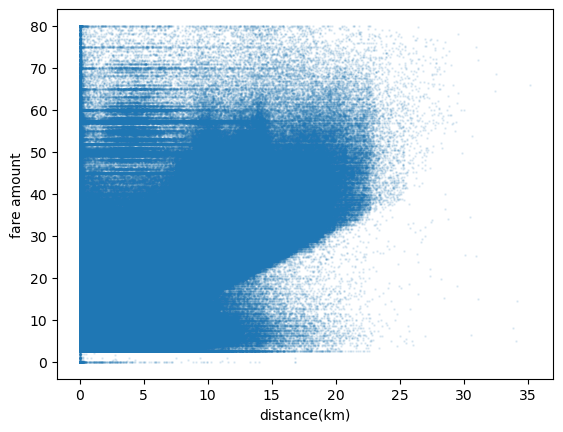

In [12]:
plt.scatter(df_train['distance'], df_train['fare_amount'], marker='.', alpha=0.1, s=3)
plt.xlabel('distance(km)')
plt.ylabel('fare amount')
plt.show()

In [13]:
from datetime import datetime
tqdm.pandas()
start_time = time()
df_train_dt = df_train
df_train_dt['pickup_datetime'] = df_train_dt['pickup_datetime'].progress_apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC"))
df_train_dt['pickup_datetime'] = df_train_dt['pickup_datetime'].progress_apply(pd.to_datetime)
print('Time for datetime transformation without pooling:', time()-start_time)

100%|██████████| 52672664/52672664 [02:53<00:00, 303184.96it/s]

Time for datetime transformation without pooling: 600.2740678787231


In [ ]:
from datetime import datetime
import multiprocessing
from multiprocessing import Pool
def convert_datetime(chunk):
    return pd.to_datetime(chunk['pickup_datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC")))

num_cores = multiprocessing.cpu_count()
chunk_size = len(df_train) // (num_cores-1)
chunks = [df_train[i:i+chunk_size] for i in range(0, len(df_train), chunk_size)]
pool = Pool(processes=num_cores)

start_time = time()
results = pool.map(convert_datetime, chunks)
df_train['pickup_datetime'] = pd.concat(results)
pool.close()
print('Time for datetime transformation with pooling: ', time()-start_time)

In [16]:
df_train['dow'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[df_train['dow'] == 0, 'dow'] = 7

df_train['month'] = df_train['pickup_datetime'].dt.month
df_train.loc[df_train['month'] == 0, 'month'] = 12

df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['if_rush_hour'] = ((7 <= df_train['hour']) & (df_train['hour'] <= 9)) | ((16 <= df_train['hour']) & (df_train['hour'] <= 19))

df_train['if_night'] = ((22 <= df_train['hour']) | (df_train['hour'] <= 5))

In [17]:
pd.DataFrame(df_train.groupby('if_rush_hour')['fare_amount'].mean())

,fare_amount
if_rush_hour,
False,10.476278
True,10.043433


In [18]:
pd.DataFrame(df_train.groupby('if_night')['fare_amount'].mean())

,fare_amount
if_night,
False,10.138706
True,10.949095


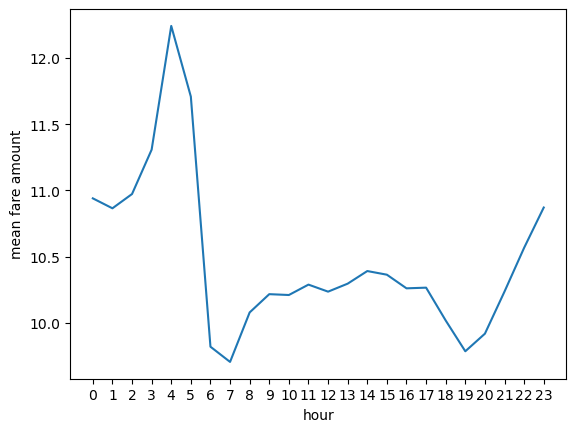

In [19]:
hour_pivot = pd.DataFrame(df_train.groupby('hour')['fare_amount'].mean())
plt.plot(hour_pivot.index, hour_pivot['fare_amount'])
plt.xlabel('hour')
plt.xticks(range(24), range(24))
plt.ylabel('mean fare amount')
plt.show()

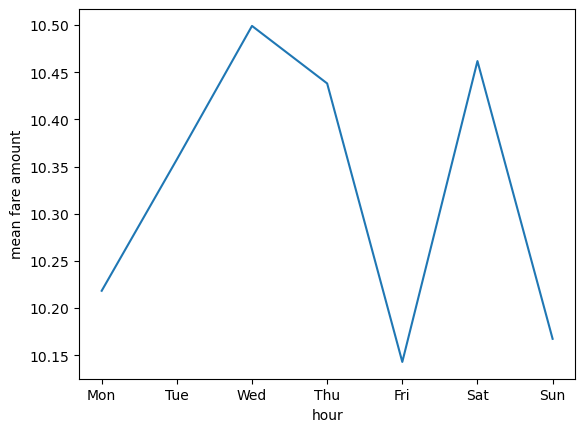

In [20]:
dow_pivot = pd.DataFrame(df_train.groupby('dow')['fare_amount'].mean())
plt.plot(dow_pivot.index, dow_pivot['fare_amount'])
plt.xticks(np.arange(7)+1, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.xlabel('hour')
plt.ylabel('mean fare amount')
plt.show()

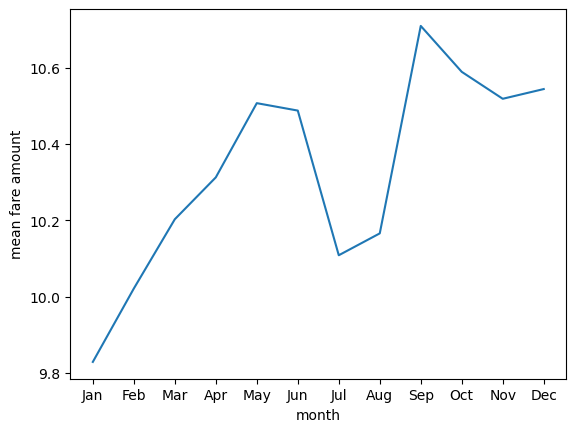

In [21]:
month_pivot = pd.DataFrame(df_train.groupby('month')['fare_amount'].mean())
plt.plot(month_pivot.index, month_pivot['fare_amount'])
plt.xticks(np.arange(12)+1, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xlabel('month')
plt.ylabel('mean fare amount')
plt.show()

/state/partition1/job-45930720/ipykernel_3675634/1578930996.py:1: FutureWarning: The provided callable <function mean at 0x14e688815160> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fare_pivot = df_train.pivot_table(index='month', columns='dow', values='fare_amount', aggfunc=np.mean)


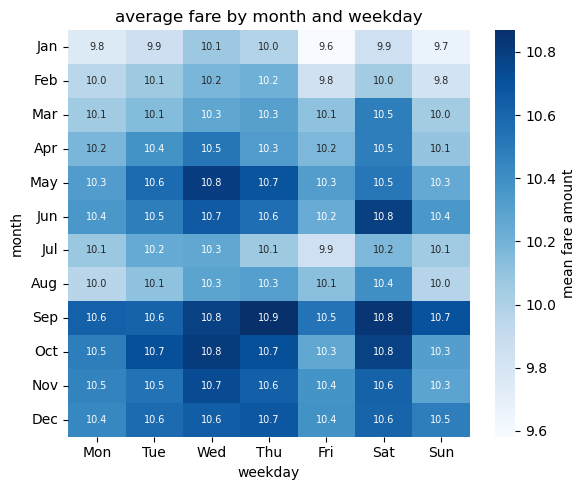

In [22]:
fare_pivot = df_train.pivot_table(index='month', columns='dow', values='fare_amount', aggfunc=np.mean)

import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(fare_pivot, cmap="Blues", annot=True, fmt=".1f", cbar_kws={'label': 'mean fare amount'}, annot_kws={'size': 7})
plt.title('average fare by month and weekday')
plt.xlabel('weekday')
plt.ylabel('month')
plt.xticks(np.arange(7) + 0.5, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks(np.arange(12) + 0.5, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.tight_layout()
plt.show()

/state/partition1/job-45930720/ipykernel_3675634/3648026740.py:1: FutureWarning: The provided callable <function mean at 0x14e688815160> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fare_pivot = df_train.pivot_table(index='dow', columns='hour', values='fare_amount', aggfunc=np.mean)


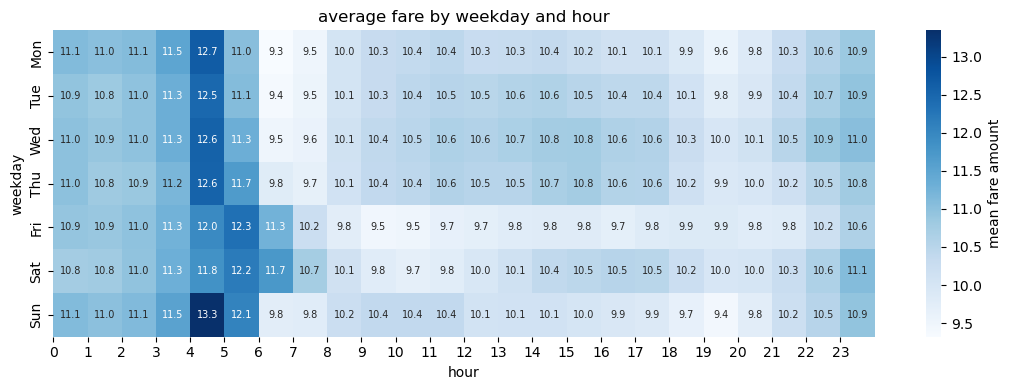

In [23]:
fare_pivot = df_train.pivot_table(index='dow', columns='hour', values='fare_amount', aggfunc=np.mean)

import seaborn as sns
plt.figure(figsize=(11, 4))
sns.heatmap(fare_pivot, cmap="Blues", annot=True, fmt=".1f", cbar_kws={'label': 'mean fare amount'}, annot_kws={'size': 7})
plt.title('average fare by weekday and hour')
plt.xlabel('hour')
plt.ylabel('weekday')
plt.yticks(np.arange(7) + 0.5, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xticks(np.arange(24), np.arange(24), rotation=0)
plt.tight_layout()
plt.show()

/state/partition1/job-45930720/ipykernel_3675634/4268133885.py:1: RuntimeWarning: divide by zero encountered in divide
  df_train['unit_fare'] = df_train['fare_amount'].values / df_train['distance'].values
/state/partition1/job-45930720/ipykernel_3675634/4268133885.py:2: FutureWarning: The provided callable <function mean at 0x14e688815160> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fare_pivot = (df_train[df_train['distance'] >= 0.5]).pivot_table(index='dow', columns='hour', values='unit_fare', aggfunc=np.mean)


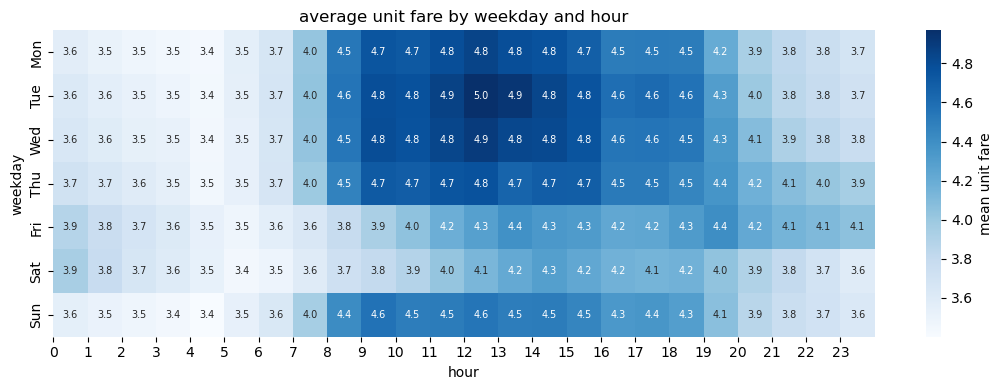

In [24]:
df_train['unit_fare'] = df_train['fare_amount'].values / df_train['distance'].values
fare_pivot = (df_train[df_train['distance'] >= 0.5]).pivot_table(index='dow', columns='hour', values='unit_fare', aggfunc=np.mean)

plt.figure(figsize=(11, 4))
sns.heatmap(fare_pivot, cmap="Blues", annot=True, fmt=".1f", cbar_kws={'label': 'mean unit fare'}, annot_kws={'size': 7})
plt.title('average unit fare by weekday and hour')
plt.xlabel('hour')
plt.ylabel('weekday')
plt.yticks(np.arange(7) + 0.5, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xticks(np.arange(24), np.arange(24), rotation=0)
plt.tight_layout()
plt.show()